## Credit Card Fraud Detection

In this project you will predict fraudulent credit card transactions with the help of Machine learning models. Please import the following libraries to get started.

In [1]:
import datetime

# Get the current date and time
current_datetime = datetime.datetime.now()

formatted_datetime = current_datetime.strftime("%Y-%m-%d %H:%M:%S")
print("Start Date and Time:", formatted_datetime)


Start Date and Time: 2023-09-24 01:02:13


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
import time

from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report
import xgboost as xgb
from xgboost import XGBClassifier

from imblearn import over_sampling
from imblearn.over_sampling import RandomOverSampler


## Exploratory data analysis

In [3]:
# Dataset source - https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Specify the path to your CSV file in Google Drive
file_path = '/content/drive/My Drive/5_MS_DataScience_UOA/Assignments/CC_Data/creditcard.csv'
#print(file_path)

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path, encoding='utf-8', on_bad_lines='skip')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
#observe the different feature type present in the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
# Checking for the missing value present in each columns
df.isnull().sum().sort_values(ascending = False)

Time      0
V16       0
Amount    0
V28       0
V27       0
V26       0
V25       0
V24       0
V23       0
V22       0
V21       0
V20       0
V19       0
V18       0
V17       0
V15       0
V1        0
V14       0
V13       0
V12       0
V11       0
V10       0
V9        0
V8        0
V7        0
V6        0
V5        0
V4        0
V3        0
V2        0
Class     0
dtype: int64

#### Observation : There is no missing value present in the dataset.

In [6]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


#### Observation : The 28 V columns are in the same scale. Amount and Time needs to be scaled.

Here we will observe the distribution of our classes

In [7]:
classes=df['Class'].value_counts()
normal_share=classes[0]/df['Class'].count()*100
fraud_share=classes[1]/df['Class'].count()*100

print("Class Distribution is : ")
print(classes)
print("Percentage of Normal Transactions is : ", normal_share)
print("Percentage of Fraud Transactions is : ", fraud_share)

Class Distribution is : 
0    284315
1       492
Name: Class, dtype: int64
Percentage of Normal Transactions is :  99.82725143693798
Percentage of Fraud Transactions is :  0.1727485630620034


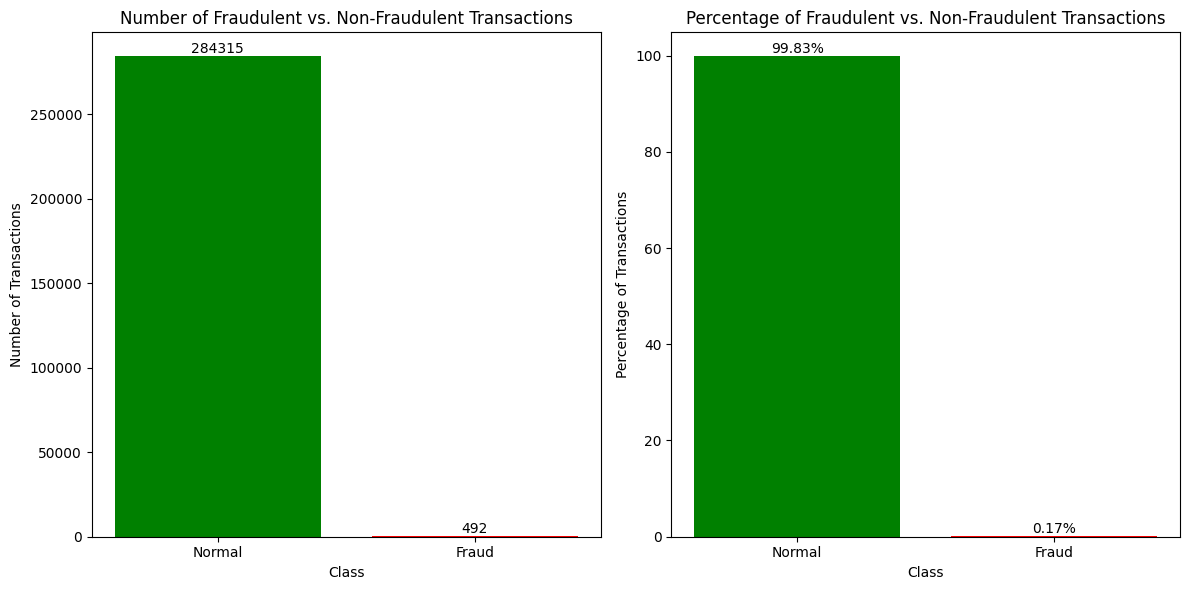

In [8]:
# Create a bar plot for the number and percentage of fraudulent vs non-fraudulent transcations

# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Create a bar plot for the number of transactions
axes[0].bar(['Normal', 'Fraud'], classes.values, color=['green', 'red'])
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Number of Transactions')
axes[0].set_title('Number of Fraudulent vs. Non-Fraudulent Transactions')

# Print values on top of the bars
for i, v in enumerate(classes.values):
    axes[0].text(i, v, str(v), ha='center', va='bottom')

# Create a bar plot for the percentage distribution
axes[1].bar(['Normal', 'Fraud'], [normal_share, fraud_share], color=['green', 'red'])
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Percentage of Transactions')
axes[1].set_title('Percentage of Fraudulent vs. Non-Fraudulent Transactions')
# Print values on top of the bars
for i, v in enumerate([normal_share, fraud_share]):
    axes[1].text(i, v, f'{v:.2f}%', ha='center', va='bottom')

# Show the subplots side by side
plt.tight_layout()
plt.show()


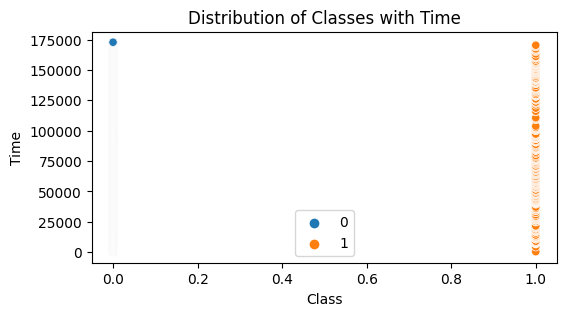

In [9]:
# Create a scatter plot to observe the distribution of classes with time

# Create a scatter plot
plt.figure(figsize=(6, 3))
sns.scatterplot(data=df, x='Class', y='Time', hue='Class')
plt.xlabel('Class')
plt.ylabel('Time')
plt.title('Distribution of Classes with Time')
plt.legend()
plt.show()


#### Observation : Fraud transactions are present across time

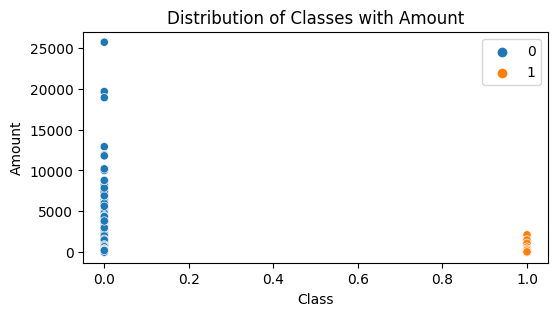

In [10]:
# Create a scatter plot to observe the distribution of classes with Amount

# Create a scatter plot
plt.figure(figsize=(6, 3))
sns.scatterplot(data=df, x='Class', y='Amount', hue='Class')
plt.xlabel('Class')
plt.ylabel('Amount')
plt.title('Distribution of Classes with Amount')
plt.legend()
plt.show()


#### Observation : Fraud transaction is present for lower transation values

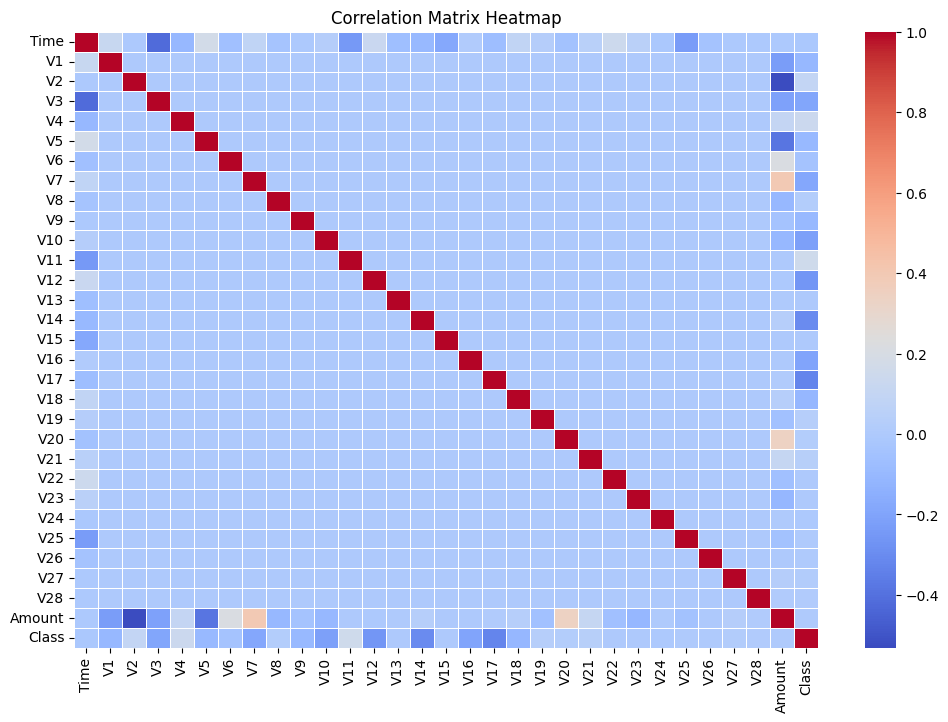

In [11]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Create a heatmap with color coding and legend
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix Heatmap")

plt.show()


#### Observation : There is no strong correlation between features

### Plotting the Distribution of the class for all features

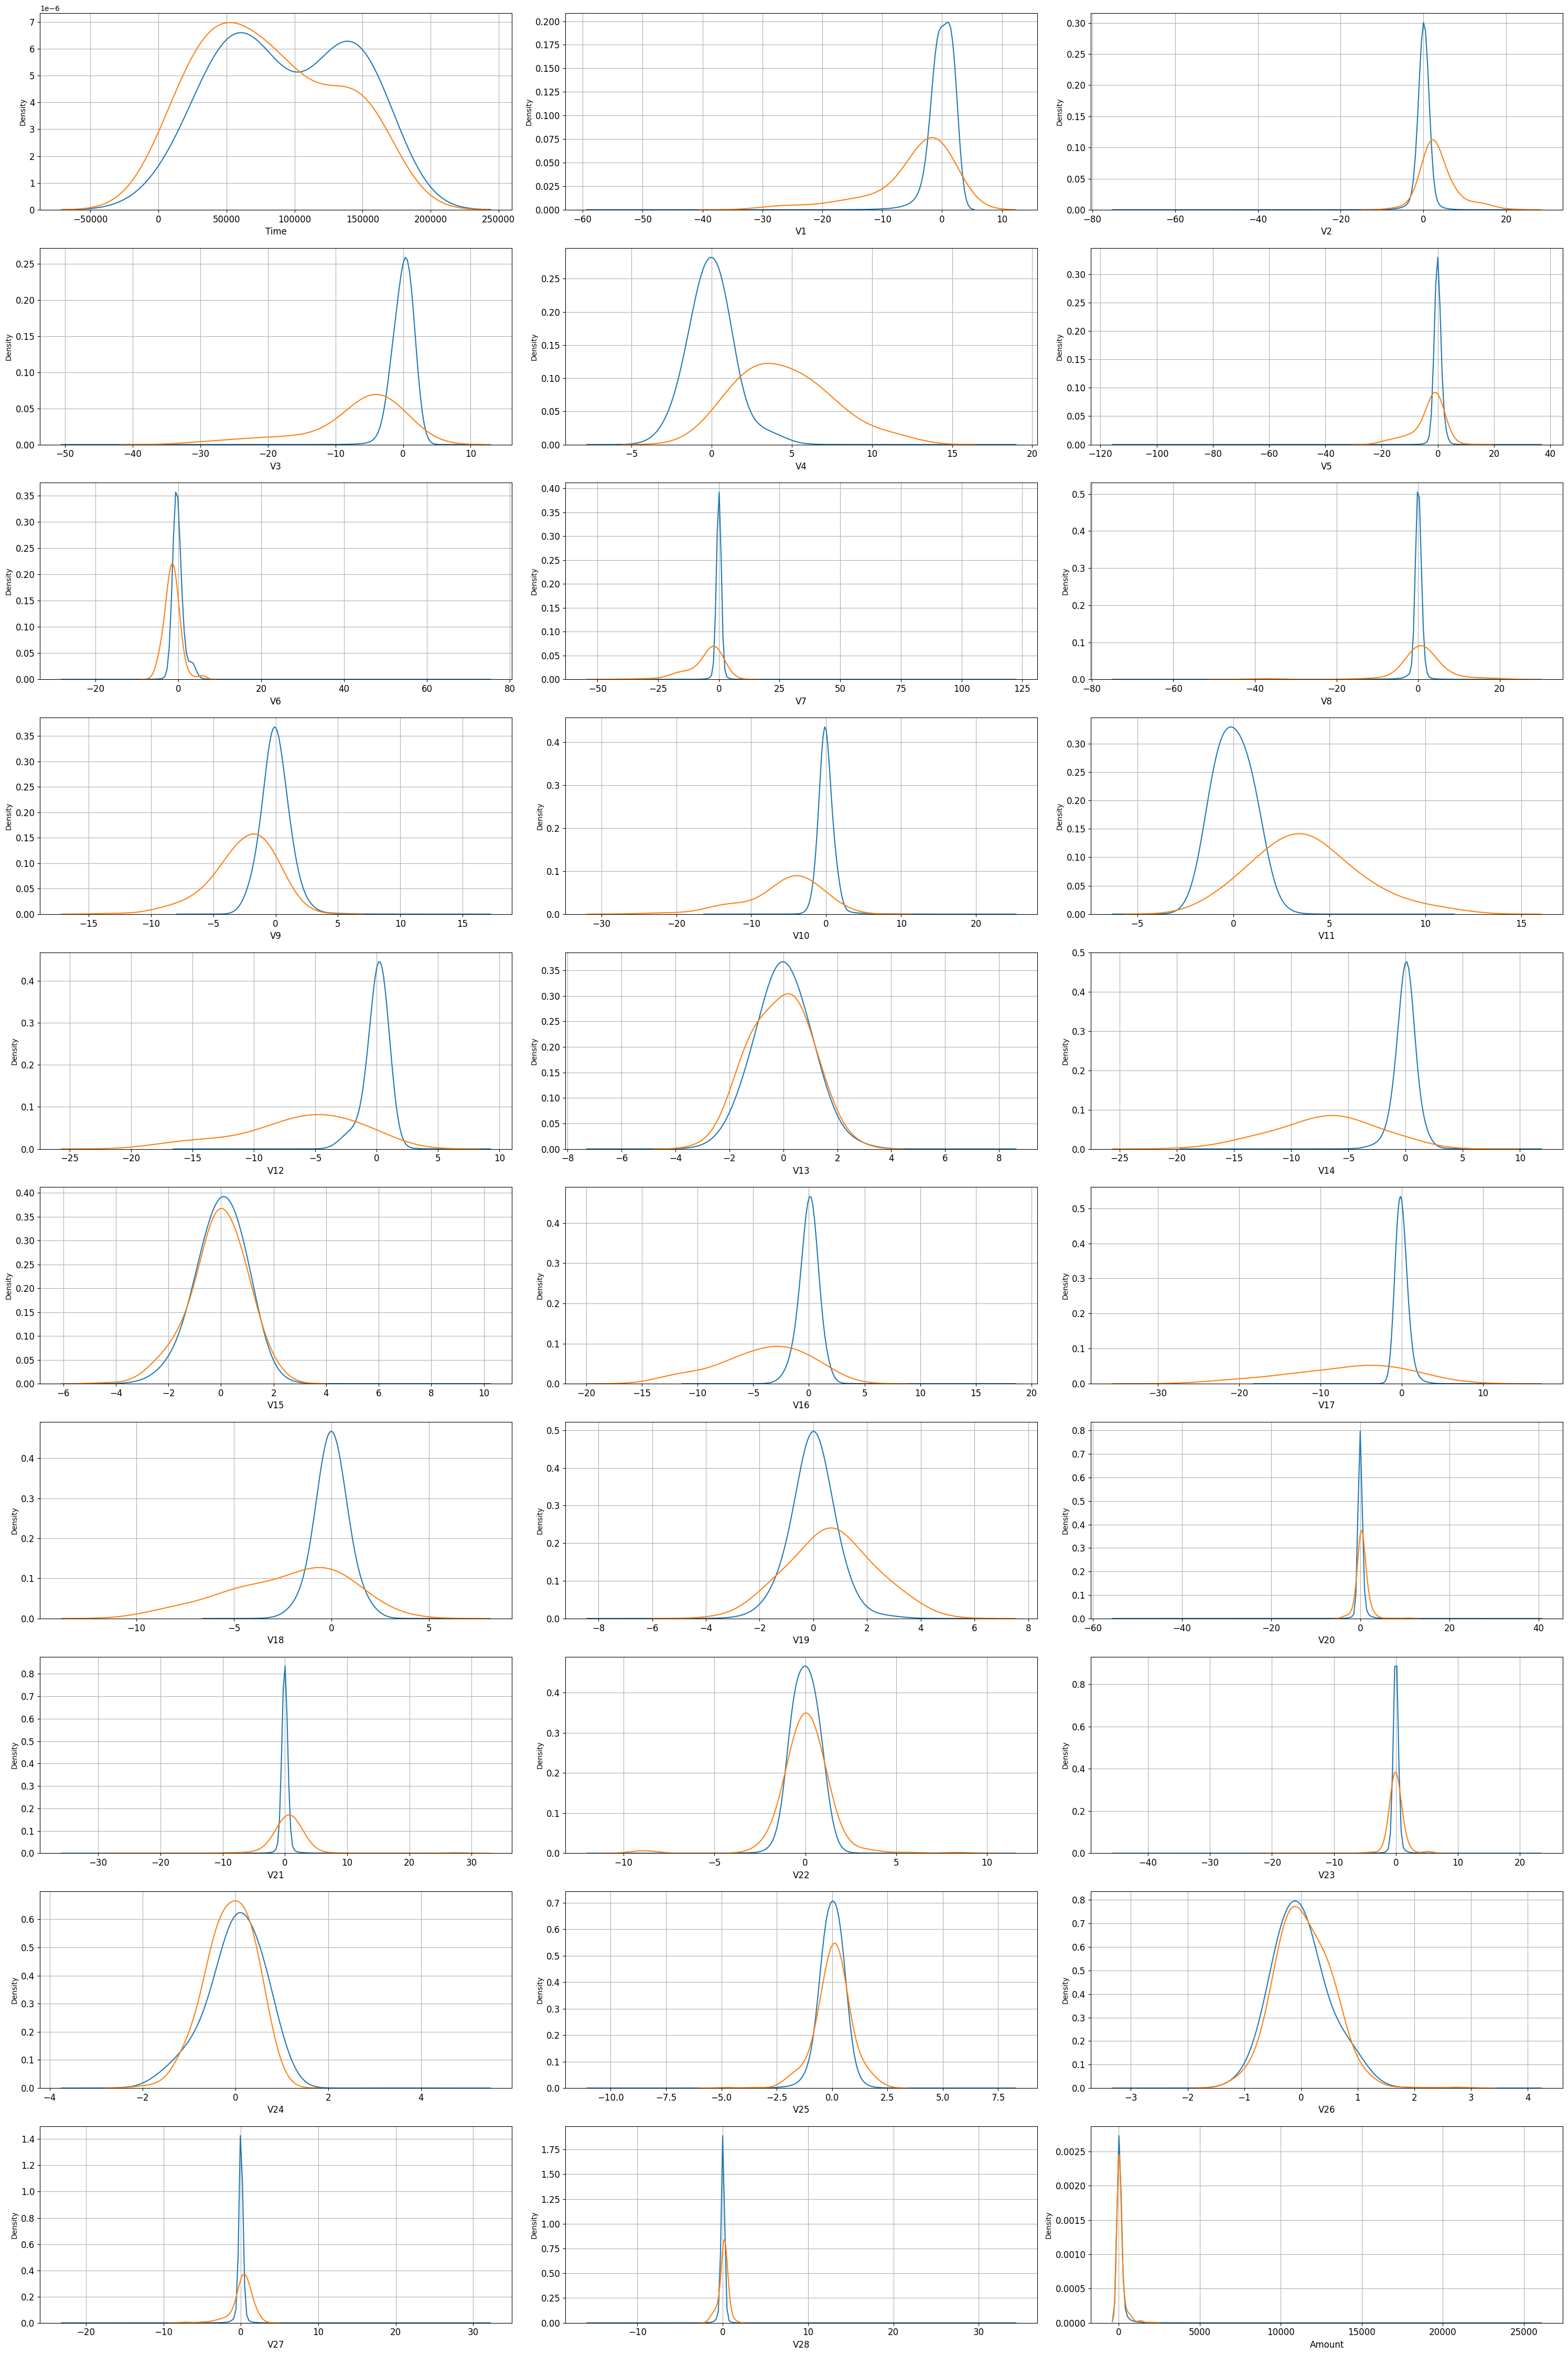

In [12]:
#import seaborn as sns
#import matplotlib.pyplot as plt
#import warnings

# Suppress warnings
#warnings.filterwarnings("ignore")

# Separate the data for each class
t0 = df[df['Class'] == 0]
t1 = df[df['Class'] == 1]

# List of numerical feature names (excluding 'Class')
features = df.drop(columns=['Class']).columns

# Set up subplots
fig, axes = plt.subplots(10, 3, figsize=(30, 45))
axes = axes.flatten()

# Plot distributions for each feature
for i, feature in enumerate(features):
    sns.kdeplot(data=t0[feature], bw_method=0.5, label="Class 0", ax=axes[i])
    sns.kdeplot(data=t1[feature], bw_method=0.5, label="Class 1", ax=axes[i])

    axes[i].set_xlabel(feature, fontsize=12)
    axes[i].tick_params(axis='both', which='major', labelsize=12)
    axes[i].grid()

plt.tight_layout()
plt.show()


#### Observations : Most of the feature is overlapping for both of the classes. Time column can be dropped as it would not help with model building.

In [13]:
# Drop unnecessary columns
df = df.drop("Time", axis=1)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [14]:
#from sklearn.preprocessing import StandardScaler

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit and transform the 'Amount' column
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))

# Now, the 'Amount' column is scaled
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


### Splitting the data into train & test data

In [15]:
#class variable

y= df["Class"]
X = df.drop("Class", axis = 1)
y.shape,X.shape

((284807,), (284807, 29))

In [16]:
#Train-Test split - 80% Training Data and 20% Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42,stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((227845, 29), (56962, 29), (227845,), (56962,))

##### Preserve X_test & y_test to evaluate on the test data once you build the model

In [17]:
print("Total Number of Fradulent transactions         : ", np.sum(y))
print("Number of Fradulent transactions in Train data : ", np.sum(y_train))
print("Number of Fradulent transactions in Test data  : ", np.sum(y_test))

Total Number of Fradulent transactions         :  492
Number of Fradulent transactions in Train data :  394
Number of Fradulent transactions in Test data  :  98


### Plotting the distribution of a variable

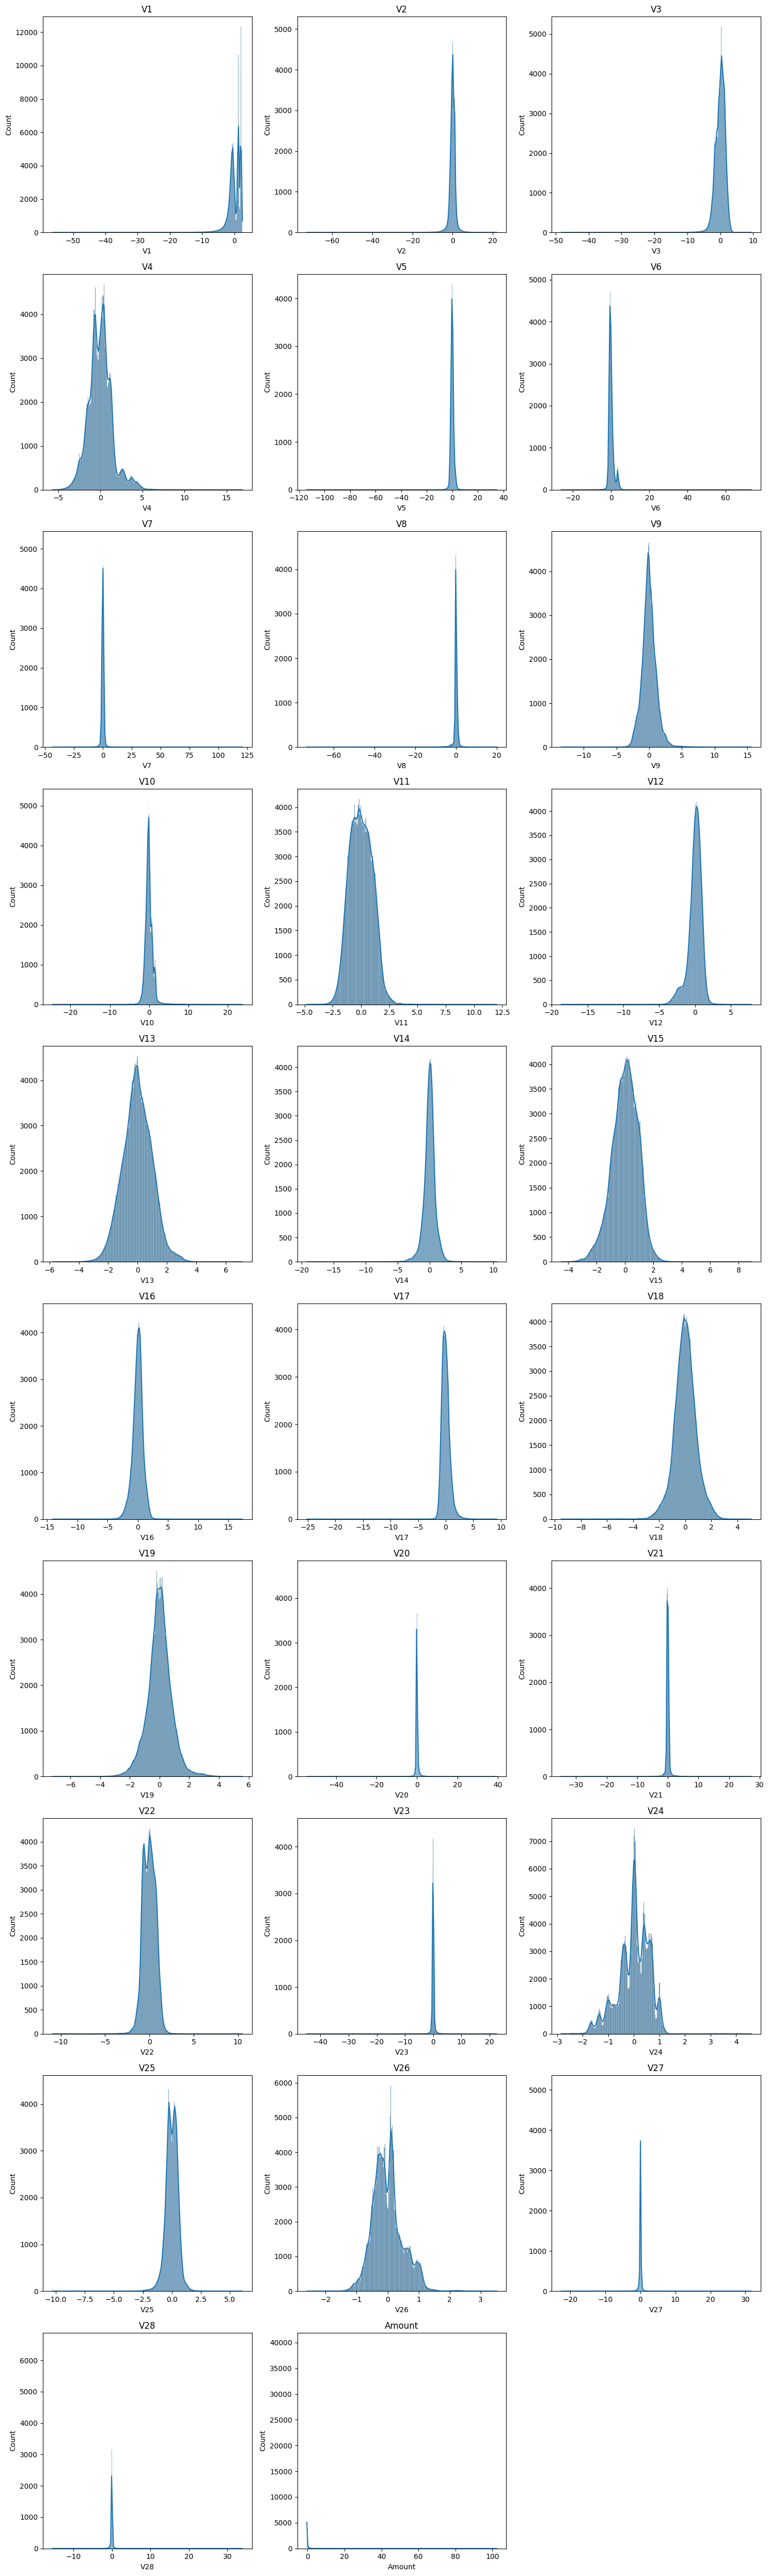

In [18]:
# plot the histogram of a variable from the dataset to see the skewness

# Get the column names
var = X_train.columns

# Calculate the number of rows and columns for subplots
num_cols = len(var)
num_rows = (num_cols - 1) // 3 + 1  # 3 columns per row

# Create subplots
plt.figure(figsize=(15, 5 * num_rows))
for i, col in enumerate(var, 1):
    plt.subplot(num_rows, 3, i)
    sns.histplot(X_train[col], kde=True)
    plt.title(col)

plt.tight_layout()
plt.show()


#### Observation : Lot of features are highly skewed. So we will check the skewness using skew() and if the skewness is beyond -1 to 1, then we will use power transform to transform the data.

### If there is skewness present in the distribution use:
- <b>Power Transformer</b> package present in the <b>preprocessing library provided by sklearn</b> to make distribution more gaussian

In [19]:
# Calculate skewness for each feature and store it in a DataFrame
skew_df = pd.DataFrame({'Features': X_train.columns, 'Skewness': X_train.skew()})
skew_df.set_index('Features', inplace=True)

skewed = skew_df[abs(skew_df['Skewness']) > 1].index.tolist()

#from sklearn.preprocessing import PowerTransformer

# preprocessing.PowerTransformer(copy=False) to fit & transform the train & test data
pt = PowerTransformer()

# Fitting the power transformer in train data
X_train[skewed] = pt.fit_transform(X_train[skewed])


# Transforming the test data
X_test[skewed] = pt.transform(X_test[skewed])

# Set options to display all columns and increase the column width
pd.set_option('display.max_columns', None)  # Set to None to display all columns
pd.set_option('display.width', None)  # Set to None to display without line wrapping
X_train


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
265518,1.336188,-0.544845,-0.965606,-0.661630,1.098808,2.530347,-1.195983,1.193358,1.406819,-0.106992,-0.113729,0.455748,0.061258,-0.150225,1.328702,0.352829,-0.924246,0.141938,-0.451365,-0.176355,0.122260,0.297537,0.490592,0.690980,-0.350316,-0.388907,0.077641,-0.090864,-0.820996
180305,1.425774,-0.116737,-1.776576,0.247945,2.186342,2.157106,-0.000786,0.641573,0.045826,0.304136,-0.254903,0.208679,-0.405327,0.766264,-0.148445,-0.892874,-0.359582,-0.695698,-0.274411,-0.296564,0.070475,0.228197,0.045872,0.707090,0.512885,-0.471198,0.002520,-0.205597,-0.969769
42664,-0.754387,0.330483,0.399881,-0.992425,-0.605729,1.414925,-1.789942,-3.636030,0.000772,-2.010828,-0.386845,2.650201,0.747777,0.056656,-1.723285,1.391102,-0.878343,0.147255,0.004631,1.674510,-4.186769,0.109526,-0.705914,-0.932803,0.826684,0.913773,0.038049,0.579844,1.560050
198723,1.686538,-0.960299,-0.630097,-1.668119,-1.008630,-0.179880,-1.154125,-0.068541,-1.118447,1.564049,0.093136,-0.866443,-0.468757,-0.285627,-0.638683,-0.153416,0.050786,0.768237,0.257424,-0.636737,-0.177824,0.077013,0.327068,-0.538236,-0.278032,-0.162068,0.018045,-0.186850,-0.862210
82325,-0.504203,-0.692345,-0.071695,-3.454854,0.512868,-0.008022,0.407953,-0.188334,-0.044782,-0.498444,-0.251076,-0.241971,-0.782698,0.069992,-0.483007,-2.148274,-0.509015,1.597589,-0.082746,-0.358673,-0.323872,-0.173298,-0.022355,-1.362383,-0.292234,-0.144622,-0.032580,-0.190564,0.900885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233802,1.383777,-0.406483,-0.554939,0.129845,-0.218496,0.410783,-0.663827,0.156331,0.995898,0.238431,0.319897,0.559422,-0.251486,-0.010446,0.013795,0.785053,-1.080529,0.739436,0.043943,-0.227667,0.376595,0.884510,0.149005,0.275689,-0.195404,0.623598,-0.032455,-0.172933,-0.865953
85418,-0.959025,0.370105,1.193161,-0.024286,0.416056,1.019681,0.492506,0.057272,0.452745,0.142942,0.521818,0.271085,-0.533295,-0.495326,0.771781,-1.957452,1.564917,-2.623211,-1.241768,-0.293717,-0.083732,0.299172,0.166737,-0.615980,-0.425883,0.263968,-0.448445,0.149437,0.025803
29062,0.520966,-0.037653,0.221677,1.505318,-0.286974,-0.197161,0.082167,-0.104479,0.319684,-0.082346,-0.305690,0.367066,-0.547450,0.106068,-0.073930,-0.936158,0.464533,-1.033061,-0.500426,-0.195745,-0.069139,-0.044629,-0.092873,0.400171,0.593314,-0.335160,0.031014,0.086641,0.217490
13766,0.704004,0.116841,0.092102,0.512720,0.035081,-0.006660,-0.116553,-0.167365,1.111187,-0.214093,1.708922,-1.554359,2.119731,2.206450,-0.357245,0.814062,-0.332803,0.483059,0.278512,-0.123670,-0.561406,-0.961351,0.042007,-0.560429,0.278428,0.089546,-0.059835,-0.008836,-1.044461


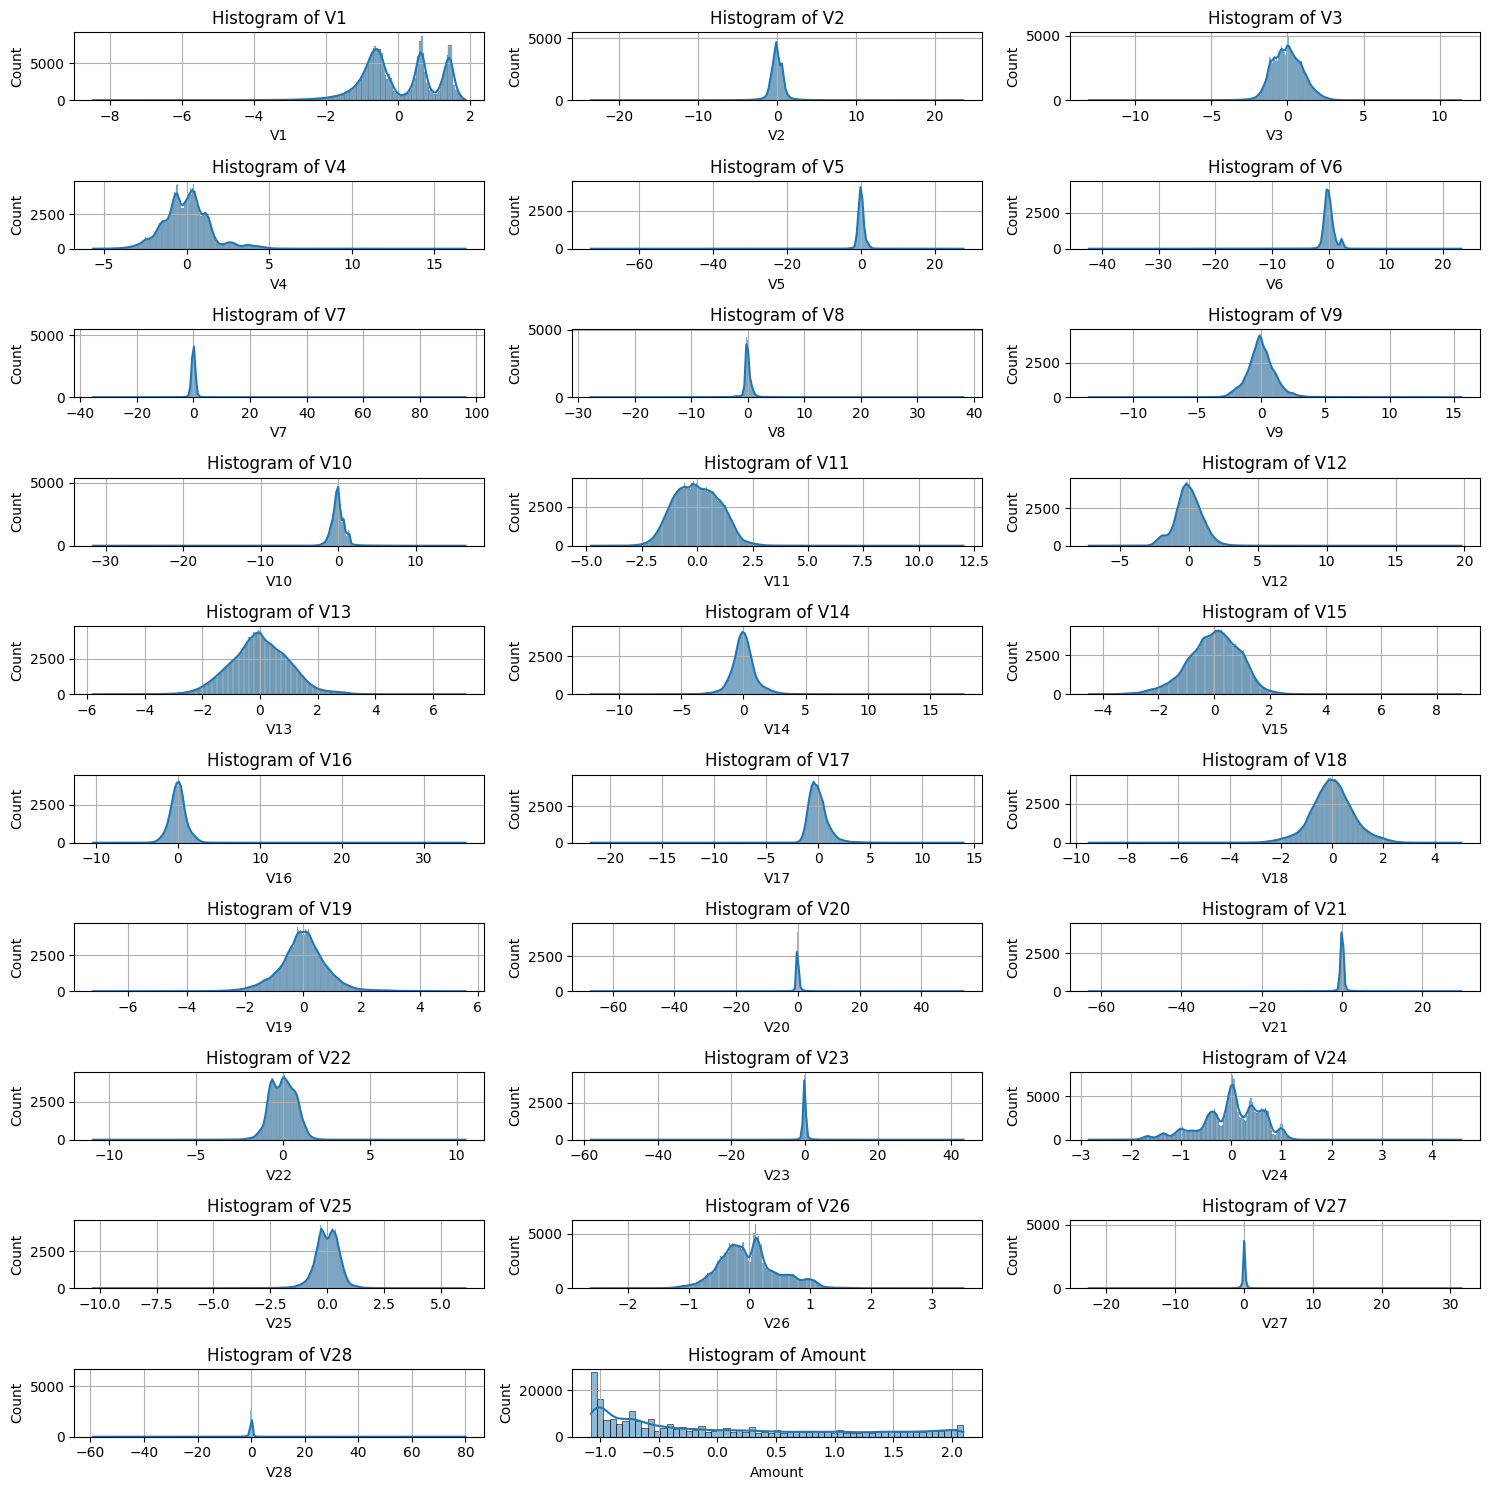

In [20]:
#import matplotlib.pyplot as plt

# Select the numerical columns you want to plot
numerical_columns = X_train.select_dtypes(include=['number']).columns

# Set the number of rows and columns for subplots
num_rows = len(numerical_columns) // 3 + 1
num_cols = 3

# Create a figure and axes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

# Flatten the axes for easy iteration
axes = axes.ravel()

# Loop through numerical columns and plot histograms
for i, col in enumerate(numerical_columns):
    sns.histplot(X_train[col], ax=axes[i], kde=True)
    axes[i].set_title(f'Histogram of {col}')
    axes[i].grid()

# Remove any empty subplots
for i in range(len(numerical_columns), num_rows * num_cols):
    fig.delaxes(axes[i])

# Adjust spacing between subplots
plt.tight_layout()
plt.show()


## Model Building
- Build different models on the imbalanced dataset and see the result

In [21]:
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)

X_train.shape: (227845, 29)
y_train.shape: (227845,)


In [22]:
# Logistic Regression
# List of values for hyperparameter 'C'
num_C = [0.001, 0.01, 0.1, 1, 10]

# List of values for cross-validation (cv)
cv_num = 5

# Initialize variables for storing the best model and its evaluation score
best_model = None
best_score = 0.0

#### perfom cross validation on the X_train & y_train to create:
- X_train_cv
- X_test_cv
- y_train_cv
- y_test_cv

In [23]:
# Initialize the Logistic Regression model
logistic_regression = LogisticRegression(max_iter=1000)

# Perform cross-validation
cv_scores = cross_val_score(logistic_regression, X_train, y_train, cv=cv_num, scoring='roc_auc')

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", np.mean(cv_scores))

# Split the data into training and test sets (you can adjust the test_size)
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

Cross-validation scores: [0.97279428 0.98558259 0.97094173 0.97620593 0.99012302]
Mean CV accuracy: 0.9791295087175772


In [24]:
# Initialize variables to store the best model and its evaluation score
best_model = None
best_roc_auc = 0.0
best_param = None

# Define a list of values for the 'C' hyperparameter
num_C = [0.001, 0.01, 0.1, 1, 10]

# Initialize the Logistic Regression model
logistic_regression = LogisticRegression(max_iter=1000)

# Initialize variables to store the execution time
start_time = time.time()

# Perform hyperparameter tuning using GridSearchCV
for C_value in num_C:
    logistic_regression.C = C_value
    logistic_regression.fit(X_train_cv, y_train_cv)

    # Make predictions on the test dataset
    y_prob_cv = logistic_regression.predict_proba(X_test_cv)[:, 1]
    roc_auc = roc_auc_score(y_test_cv, y_prob_cv)

    # Check if this model is the best so far
    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_model = logistic_regression.__class__.__name__
        best_param = C_value

# Calculate the execution time
end_time = time.time()
elapsed_time = end_time - start_time

# Print evaluation metrics including ROC AUC
print(f"\nBest Model ({best_model}) with ROC AUC on the test dataset: {best_roc_auc:.4f}")
print(f"Optimal 'C' Parameter: {best_param}")
print(f"Time Taken for Model Execution: {elapsed_time:.2f} seconds")

# Evaluate the model on the separate test dataset (X_test and y_test)
y_pred_test = logistic_regression.predict(X_test)

# Calculate ROC AUC for the test dataset
y_prob_test = logistic_regression.predict_proba(X_test)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_prob_test)

# Evaluate the model's performance on the test dataset
accuracy_test = accuracy_score(y_test, y_pred_test)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
class_report_test = classification_report(y_test, y_pred_test)

# Print evaluation metrics for the test dataset
print("\nAccuracy on the separate test dataset:", accuracy_test)
print("ROC AUC on the separate test dataset:", roc_auc_test)
print("\nConfusion Matrix for the test dataset:\n", conf_matrix_test)
print("\nClassification Report for the test dataset:\n", class_report_test)



Best Model (LogisticRegression) with ROC AUC on the test dataset: 0.9695
Optimal 'C' Parameter: 0.01
Time Taken for Model Execution: 3.22 seconds

Accuracy on the separate test dataset: 0.9991573329588147
ROC AUC on the separate test dataset: 0.9636267844222663

Confusion Matrix for the test dataset:
 [[56850    14]
 [   34    64]]

Classification Report for the test dataset:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.82      0.65      0.73        98

    accuracy                           1.00     56962
   macro avg       0.91      0.83      0.86     56962
weighted avg       1.00      1.00      1.00     56962



### Similarly explore other algorithms by building models like:
- KNN
- SVM
- Decision Tree
- Random Forest
- XGBoost

In [25]:
# # List of models
# models = [
#     ("K-Nearest Neighbors", KNeighborsClassifier()),
#     ("Decision Tree", DecisionTreeClassifier(random_state=42)),
#     ("Random Forest", RandomForestClassifier(random_state=42)),
#     #("SVM", SVC(kernel='linear', probability=True, random_state=42)),  # SVM model commented during development phase as it runs longer
#     ("XGBoost", xgb.XGBClassifier(random_state=42))
# ]

# # Initialize variables for storing the best model and its evaluation score
# best_model = None
# best_score = 0.0
# best_params = None

# # Initialize a list to store results
# results = []

# # Progress bar initialization
# total_models = len(models)
# current_model = 0

# # Iterate through models
# for model_name, model in models:
#     current_model += 1
#     print(f"Training {model_name} ({current_model}/{total_models})...")

#     start_time = time.time()  # Record start time

#     # Perform cross-validation
#     scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')

#     end_time = time.time()  # Record end time
#     elapsed_time = end_time - start_time  # Calculate elapsed time

#     # Calculate mean ROC AUC score
#     mean_score = scores.mean()

#     print(f"{model_name} - Mean ROC AUC: {mean_score:.4f}, Time Taken: {elapsed_time:.2f} seconds")

#     # Check if this model is the best so far
#     if mean_score > best_score:
#         best_score = mean_score
#         best_model = model_name
#         best_params = model.get_params()  # Get the best hyperparameters

#     # Store results in the list
#     results.append({
#         'model_name': model_name,
#         'best_score': mean_score,
#         'best_params': model.get_params(),
#         'time_taken': elapsed_time
#     })

# print(f"\nBest Model: {best_model} with ROC AUC score of {best_score:.4f}")

# # Create a dataframe from the results list
# results_df = pd.DataFrame(results)

# # Print the dataframe
# print("\nResults DataFrame:")
# print(results_df)


In [26]:
# List of models
models = [
    ("K-Nearest Neighbors", KNeighborsClassifier()),
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("Random Forest", RandomForestClassifier(random_state=42)),
    #("SVM", SVC(kernel='linear', probability=True, random_state=42)),  # SVM model commented during development phase as it runs longer
    ("XGBoost", xgb.XGBClassifier(random_state=42))
]

# Initialize variables for storing the best model and its evaluation score
best_model = None
best_score = 0.0
best_params = None

# Initialize a list to store results
results = []

# Progress bar initialization
total_models = len(models)
current_model = 0

# Iterate through models
for model_name, model in models:
    current_model += 1
    print(f"Training {model_name} ({current_model}/{total_models})...")

    start_time = time.time()  # Record start time

    # Perform cross-validation
    scores = cross_val_score(model, X_train_cv, y_train_cv, cv=5, scoring='roc_auc')

    end_time = time.time()  # Record end time
    elapsed_time = end_time - start_time  # Calculate elapsed time

    # Calculate mean ROC AUC score
    mean_score = scores.mean()

    print(f"{model_name} - Mean ROC AUC: {mean_score:.4f}, Time Taken: {elapsed_time:.2f} seconds")

    # Check if this model is the best so far
    if mean_score > best_score:
        best_score = mean_score
        best_model = model_name
        best_params = model.get_params()  # Get the best hyperparameters

    # Store results in the list
    results.append({
        'model_name': model_name,
        'best_score': mean_score,
        'best_params': model.get_params(),
        'time_taken': elapsed_time
    })

print(f"\nBest Model: {best_model} with ROC AUC score of {best_score:.4f}")

# Train the best model on the entire training dataset
best_model_instance = [model for model in models if model[0] == best_model][0][1]
best_model_instance.fit(X_train_cv, y_train_cv)

# Evaluate the best model on the test dataset (X_test_cv and y_test_cv)
test_roc_auc = roc_auc_score(y_test_cv, best_model_instance.predict_proba(X_test_cv)[:, 1])
print(f"{best_model} - ROC AUC on Test Data: {test_roc_auc:.4f}")

# Create a dataframe from the results list
results_df = pd.DataFrame(results)

# Print the dataframe
print("\nResults DataFrame:")
print(results_df)


Training K-Nearest Neighbors (1/4)...
K-Nearest Neighbors - Mean ROC AUC: 0.9141, Time Taken: 33.94 seconds
Training Decision Tree (2/4)...
Decision Tree - Mean ROC AUC: 0.8712, Time Taken: 51.07 seconds
Training Random Forest (3/4)...
Random Forest - Mean ROC AUC: 0.9443, Time Taken: 532.11 seconds
Training XGBoost (4/4)...
XGBoost - Mean ROC AUC: 0.9803, Time Taken: 87.34 seconds

Best Model: XGBoost with ROC AUC score of 0.9803
XGBoost - ROC AUC on Test Data: 0.9694

Results DataFrame:
            model_name  best_score  \
0  K-Nearest Neighbors    0.914150   
1        Decision Tree    0.871217   
2        Random Forest    0.944287   
3              XGBoost    0.980303   

                                         best_params  time_taken  
0  {'algorithm': 'auto', 'leaf_size': 30, 'metric...   33.943810  
1  {'ccp_alpha': 0.0, 'class_weight': None, 'crit...   51.074209  
2  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...  532.113728  
3  {'objective': 'binary:logistic', 'use_label_

In [27]:
results_df

,model_name,best_score,best_params,time_taken
0,K-Nearest Neighbors,0.914150,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",33.943810
1,Decision Tree,0.871217,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",51.074209
2,Random Forest,0.944287,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",532.113728
3,XGBoost,0.980303,"{'objective': 'binary:logistic', 'use_label_en...",87.337308


**Observation** : XGBoost model is best performing model

#### Proceed with the model which shows the best result
- Apply the best hyperparameter on the model
- Predict on the test dataset

In [28]:
# # from sklearn.model_selection import train_test_split, GridSearchCV, KFold
# # from xgboost import XGBClassifier
# # from sklearn.metrics import roc_auc_score
# # from tqdm import tqdm
# # import time

# # Split the data into train, validation, and test sets
# X_train, X_temp, y_train, y_temp = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# models_to_explore = [
#     {
#         'model_name': 'XGBoost',
#         'model': XGBClassifier(),
#         'param_grid': {
#             'n_estimators': [100], # value taken from the best param
#             'max_depth': [3, 4, 5], # the next values are randomly chosen
#             'learning_rate': [0.01, 0.1, 0.2]
#         }
#     },
# ]

# # Initialize variables for storing the best model and its evaluation score
# best_model = None
# best_roc_auc = 0.0

# # Create a tqdm progress bar for hyperparameter tuning
# progress_bar = tqdm(total=len(models_to_explore), desc="Exploring Models")

# for model_info in models_to_explore:
#     model_name = model_info['model_name']
#     model = model_info['model']
#     param_grid = model_info['param_grid']

#     folds = KFold(n_splits=5, shuffle=True, random_state=42)

#     # Perform hyperparameter tuning using GridSearchCV
#     grid_search = GridSearchCV(
#         estimator=model,
#         param_grid=param_grid,
#         scoring='roc_auc',
#         cv=folds,
#         n_jobs=-1,
#         verbose=1,
#         return_train_score=True
#     )

#     # Fit the model with hyperparameter tuning
#     start_time = time.time()
#     grid_search.fit(X_train, y_train)  # Replace with your actual variable names
#     end_time = time.time()

#     # Calculate execution time for this model exploration
#     execution_time = end_time - start_time

#     # Get the best model
#     best_model_for_current = grid_search.best_estimator_

#     # Evaluate the best model on the validation data
#     y_pred = best_model_for_current.predict_proba(X_val)[:, 1]  # Replace with your actual variable names
#     roc_auc = roc_auc_score(y_val, y_pred)  # Replace with your actual variable names

#     print(f"{model_name} - ROC AUC on Validation Data: {roc_auc:.4f}")

#     if roc_auc > best_roc_auc:
#         best_model = best_model_for_current
#         best_roc_auc = roc_auc

#     # Update the progress bar
#     progress_bar.update(1)

# # Close the progress bar
# progress_bar.close()

# # Train the best model on the full training data
# best_model.fit(X_train, y_train)  # Replace with your actual variable names

# # Evaluate the best model on the test data
# y_pred = best_model.predict_proba(X_test)[:, 1]  # Replace with your actual variable names
# roc_auc = roc_auc_score(y_test, y_pred)  # Replace with your actual variable names
# print(f"Best Model ({best_model.__class__.__name__}) - ROC AUC on Test Data: {roc_auc:.4f}")

# # Assuming 'best_model' is the best trained XGBoost model
# var_imp = best_model.feature_importances_

# # Find the indices of the top 3 most important features
# top_var_indices = np.argsort(var_imp)[::-1][:3]

# # Print the names of the top 3 most important features
# print('Top 3 most important features:')
# for i, idx in enumerate(top_var_indices):
#     print(f"{i + 1}: Feature {idx}, Importance: {var_imp[idx]}")



In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import time

# Hyperparameter grid to explore
param_grid = {
    'n_estimators': [100, 200, 300],  # value taken from the best param
    'max_depth': [3, 4, 5],  # the next values are randomly chosen
    'learning_rate': [0.01, 0.1, 0.2]
}

# Initialize XGBoost model
model = XGBClassifier()

# Initialize variables for storing the best model and its evaluation score
best_model = None
best_roc_auc = 0.0

# Create a tqdm progress bar for hyperparameter tuning
progress_bar = tqdm(total=1, desc="Exploring XGBoost")

folds = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=folds,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# Fit the model with hyperparameter tuning
start_time = time.time()
grid_search.fit(X_train_cv, y_train_cv)  # Use the existing X_train_cv and y_train_cv
end_time = time.time()

# Calculate execution time for this model exploration
execution_time = end_time - start_time

# Get the best model
best_model_for_current = grid_search.best_estimator_

# Print the best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Train the best model on the full training data (X_train_cv, y_train_cv)
best_model_for_current.fit(X_train_cv, y_train_cv)

# Evaluate the best model on the final test data (X_test, y_test)
y_pred_test = best_model_for_current.predict_proba(X_test)[:, 1]  # Use the final test data X_test and y_test
roc_auc_test = roc_auc_score(y_test, y_pred_test)  # Use the final test data X_test and y_test

print(f"XGBoost - ROC AUC on Test Data: {roc_auc_test:.4f}")
print(f"XGBoost - Time Taken: {execution_time:.2f} seconds\n")

best_model = best_model_for_current  # Update the best model

# Close the progress bar
progress_bar.close()

# Assuming 'best_model' is the best trained XGBoost model
var_imp = best_model.feature_importances_

# Find the indices of the top 3 most important features
top_var_indices = np.argsort(var_imp)[::-1][:3]

# Print the names of the top 3 most important features
print('Top 3 most important features:')
for i, idx in enumerate(top_var_indices):
    print(f"{i + 1}: Feature {idx}, Importance: {var_imp[idx]}")


Exploring XGBoost:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 27 candidates, totalling 135 fits


# Print the names of the top 3 most important features

- This will not give much explanation on the already transformed dataset
- But it will help us in understanding if the dataset is not PCA transformed

In [ ]:


# Assuming 'best_model' is the best trained XGBoost model
var_imp = best_model.feature_importances_

# Find the indices of the top 3 most important features
top_var_indices = np.argsort(var_imp)[::-1][:3]

# Print the names of the top 3 most important features
print('Top 3 most important features:')
for i, idx in enumerate(top_var_indices):
    print(f"{i + 1}: Feature {idx}, Importance: {var_imp[idx]}")


# Variable on Index-16 and Index-13 seems to be the top 2 variables
top_var_index = np.argsort(var_imp)[-1]
second_top_var_index = np.argsort(var_imp)[-2]

X_train_1 = X_train.to_numpy()[np.where(y_train == 1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train == 0.0)]

np.random.shuffle(X_train_0)

plt.rcParams['figure.figsize'] = [6, 6]

plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],
            label='Actual Class-0 Examples')
plt.legend()
plt.show()

## Model building with balancing Classes

##### Perform class balancing with :
- Random Oversampling
- SMOTE
- ADASYN

## Model Building
- Build different models on the balanced dataset and see the result

#### perfom cross validation on the X_train & y_train to create:
- X_train_cv
- X_test_cv
- y_train_cv
- y_test_cv

### Random Oversampling

In [ ]:
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)

In [ ]:
# Initialize the Random Oversampler
ros = RandomOverSampler(random_state=42)

# Perform Random Oversampling on X_train and y_train
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

# Print shapes for debugging
print("Shapes after Random Over Sampling:")
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)
print("X_train_ros.shape:", X_train_ros.shape)
print("y_train_ros.shape:", y_train_ros.shape)

In [ ]:
### Logistic Regression


In [ ]:
# Define a list of values for the 'C' hyperparameter
num_C = [0.001, 0.01, 0.1, 1, 10]

# Define the number of desired cross-validation folds
cv_num = 5

# Initialize the Logistic Regression model
logistic_regression = LogisticRegression(max_iter=1000)

# # Initialize the Random Oversampler
# ros = RandomOverSampler(random_state=42)

# # Perform Random Oversampling on X_train and y_train
# X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

# Perform cross-validation
cv_scores = cross_val_score(logistic_regression, X_train_ros, y_train_ros, cv=cv_num, scoring='roc_auc')

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", np.mean(cv_scores))

# Split the data into training and test sets (you can adjust the test_size)
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_train_ros, y_train_ros, test_size=0.2, random_state=42, stratify=y_train_ros)




In [ ]:
# Initialize variables to store the best model and its evaluation score
best_model = None
best_roc_auc = 0.0
best_param = None

# Define a list of values for the 'C' hyperparameter
num_C = [0.001, 0.01, 0.1, 1, 10]

# Initialize the Logistic Regression model
logistic_regression = LogisticRegression(max_iter=1000)

# Initialize variables to store the execution time
start_time = time.time()

# Perform hyperparameter tuning using GridSearchCV
for C_value in num_C:
    logistic_regression.C = C_value
    logistic_regression.fit(X_train_cv, y_train_cv)

    # Make predictions on the test dataset
    y_prob_cv = logistic_regression.predict_proba(X_test_cv)[:, 1]
    roc_auc = roc_auc_score(y_test_cv, y_prob_cv)

    # Check if this model is the best so far
    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_model = logistic_regression.__class__.__name__
        best_param = C_value

# Calculate the execution time
end_time = time.time()
elapsed_time = end_time - start_time

# Print evaluation metrics including ROC AUC
print(f"\nBest Model ({best_model}) with ROC AUC on the test dataset: {best_roc_auc:.4f}")
print(f"Optimal 'C' Parameter: {best_param}")
print(f"Time Taken for Model Execution: {elapsed_time:.2f} seconds")

# Evaluate the model on the separate test dataset (X_test and y_test)
y_pred_test = logistic_regression.predict(X_test)

# Calculate ROC AUC for the test dataset
y_prob_test = logistic_regression.predict_proba(X_test)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_prob_test)

# Evaluate the model's performance on the test dataset
accuracy_test = accuracy_score(y_test, y_pred_test)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
class_report_test = classification_report(y_test, y_pred_test)

# Print evaluation metrics for the test dataset
print("\nAccuracy on the separate test dataset:", accuracy_test)
print("ROC AUC on the separate test dataset:", roc_auc_test)
print("\nConfusion Matrix for the test dataset:\n", conf_matrix_test)
print("\nClassification Report for the test dataset:\n", class_report_test)


### Similarly explore other algorithms on balanced dataset by building models like:
- KNN
- SVM
- Decision Tree
- Random Forest
- XGBoost

In [ ]:
# List of models
models = [
    ("K-Nearest Neighbors", KNeighborsClassifier()),
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("Random Forest", RandomForestClassifier(random_state=42)),
    #("SVM", SVC(kernel='linear', probability=True, random_state=42)),  # SVM model commented during development phase as it runs longer
    ("XGBoost", xgb.XGBClassifier(random_state=42))
]

# Initialize variables for storing the best model and its evaluation score
best_model = None
best_score = 0.0
best_params = None

# Initialize a list to store results
results = []

# Progress bar initialization
total_models = len(models)
current_model = 0

# Iterate through models
for model_name, model in models:
    current_model += 1
    print(f"Training {model_name} ({current_model}/{total_models})...")

    start_time = time.time()  # Record start time

    # Perform cross-validation
    scores = cross_val_score(model, X_train_cv, y_train_cv, cv=5, scoring='roc_auc')

    end_time = time.time()  # Record end time
    elapsed_time = end_time - start_time  # Calculate elapsed time

    # Calculate mean ROC AUC score
    mean_score = scores.mean()

    print(f"{model_name} - Mean ROC AUC: {mean_score:.4f}, Time Taken: {elapsed_time:.2f} seconds")

    # Check if this model is the best so far
    if mean_score > best_score:
        best_score = mean_score
        best_model = model_name
        best_params = model.get_params()  # Get the best hyperparameters

    # Store results in the list
    results.append({
        'model_name': model_name,
        'best_score': mean_score,
        'best_params': model.get_params(),
        'time_taken': elapsed_time
    })

print(f"\nBest Model: {best_model} with ROC AUC score of {best_score:.4f}")

# Train the best model on the entire training dataset
best_model_instance = [model for model in models if model[0] == best_model][0][1]
best_model_instance.fit(X_train_cv, y_train_cv)

# Evaluate the best model on the test dataset (X_test_cv and y_test_cv)
test_roc_auc = roc_auc_score(y_test_cv, best_model_instance.predict_proba(X_test_cv)[:, 1])
print(f"{best_model} - ROC AUC on Test Data: {test_roc_auc:.4f}")

# Create a dataframe from the results list
results_df = pd.DataFrame(results)

# Print the dataframe
print("\nResults DataFrame:")
print(results_df)


In [ ]:
results_df

In [ ]:
# # Update the code to use X_train_cv, y_train_cv, X_test_cv, and y_test_cv for train and test splits

# models_to_explore = [
#     {
#         'model_name': 'XGBoost',
#         'model': XGBClassifier(),
#         'param_grid': {
#             'n_estimators': [100],  # value taken from the best param
#             'max_depth': [3, 4, 5],  # the next values are randomly chosen
#             'learning_rate': [0.01, 0.1, 0.2]
#         }
#     },
# ]

# # Initialize variables for storing the best model and its evaluation score
# best_model = None
# best_roc_auc = 0.0

# # Create a tqdm progress bar for hyperparameter tuning
# progress_bar = tqdm(total=len(models_to_explore), desc="Exploring Models")

# for model_info in models_to_explore:
#     model_name = model_info['model_name']
#     model = model_info['model']
#     param_grid = model_info['param_grid']

#     folds = KFold(n_splits=5, shuffle=True, random_state=42)

#     # Perform hyperparameter tuning using GridSearchCV
#     grid_search = GridSearchCV(
#         estimator=model,
#         param_grid=param_grid,
#         scoring='roc_auc',
#         cv=folds,
#         n_jobs=-1,
#         verbose=1,
#         return_train_score=True
#     )

#     # Fit the model with hyperparameter tuning on the training data
#     start_time = time.time()
#     grid_search.fit(X_train_cv, y_train_cv)  # Use X_train_cv and y_train_cv
#     end_time = time.time()

#     # Calculate execution time for this model exploration
#     execution_time = end_time - start_time

#     # Get the best model
#     best_model_for_current = grid_search.best_estimator_

#     # Evaluate the best model on the validation data (X_test_cv and y_test_cv)
#     y_pred = best_model_for_current.predict_proba(X_test_cv)[:, 1]  # Use X_test_cv and y_test_cv
#     roc_auc = roc_auc_score(y_test_cv, y_pred)  # Use X_test_cv and y_test_cv

#     print(f"{model_name} - ROC AUC on Validation Data: {roc_auc:.4f}")

#     if roc_auc > best_roc_auc:
#         best_model = best_model_for_current
#         best_roc_auc = roc_auc

#     # Update the progress bar
#     progress_bar.update(1)

# # Close the progress bar
# progress_bar.close()

# # Train the best model on the full training data (X_train_cv and y_train_cv)
# best_model.fit(X_train_cv, y_train_cv)

# # Evaluate the best model on the test data (X_test_cv and y_test_cv)
# y_pred = best_model.predict_proba(X_test_cv)[:, 1]  # Use X_test_cv and y_test_cv
# roc_auc = roc_auc_score(y_test_cv, y_pred)  # Use X_test_cv and y_test_cv
# print(f"Best Model ({best_model.__class__.__name__}) - ROC AUC on Test Data: {roc_auc:.4f}")

# # Assuming 'best_model' is the best trained XGBoost model
# var_imp = best_model.feature_importances_

# # Find the indices of the top 3 most important features
# top_var_indices = np.argsort(var_imp)[::-1][:3]

# # Print the names of the top 3 most important features
# print('Top 3 most important features:')
# for i, idx in enumerate(top_var_indices):
#     print(f"{i + 1}: Feature {idx}, Importance: {var_imp[idx]}")


In [ ]:
# Hyperparameter grid to explore
param_grid = {
    'n_estimators': [100,200,300],  # value taken from the best param
    'max_depth': [3, 4, 5],  # the next values are randomly chosen
    'learning_rate': [0.01, 0.1, 0.2]
}

# Initialize XGBoost model
model = XGBClassifier()

# Initialize variables for storing the best model and its evaluation score
best_model = None
best_roc_auc = 0.0

# Create a tqdm progress bar for hyperparameter tuning
progress_bar = tqdm(total=1, desc="Exploring XGBoost")

folds = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=folds,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# Fit the model with hyperparameter tuning
start_time = time.time()
grid_search.fit(X_train_cv, y_train_cv)  # Use the existing X_train_cv and y_train_cv
end_time = time.time()

# Calculate execution time for this model exploration
execution_time = end_time - start_time

# Get the best model
best_model_for_current = grid_search.best_estimator_

# Print the best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Train the best model on the full training data (X_train_cv, y_train_cv)
best_model_for_current.fit(X_train_cv, y_train_cv)

# Assuming 'best_model' is the best trained XGBoost model
var_imp = best_model_for_current.feature_importances_

# Find the indices of the top 3 most important features
top_var_indices = np.argsort(var_imp)[::-1][:3]

# Print the names of the top 3 most important features
print('Top 3 most important features:')
for i, idx in enumerate(top_var_indices):
    print(f"{i + 1}: Feature {idx}, Importance: {var_imp[idx]}")


Check the above code if correct variables are used in predicting and plotting. Action Item for me - 9/20/2023

### Print the class distribution after applying SMOTE

In [ ]:
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)

In [ ]:
# pip install imbalanced-learn


In [ ]:
import warnings
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import numpy as np

warnings.filterwarnings("ignore")

try:
    sm = SMOTE(random_state=0)
    X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

    # Print shapes for debugging
    print("Shapes:")
    print("X_train.shape:", X_train.shape)
    print("y_train.shape:", y_train.shape)
    print("X_train_smote.shape:", X_train_smote.shape)

    # Check if X_train_smote has at least one more row than X_train
    if X_train_smote.shape[0] <= X_train.shape[0]:
        raise ValueError("SMOTE did not generate additional samples.")

    # Artificial minority samples and corresponding minority labels from SMOTE are appended
    # below X_train and y_train respectively
    # So to exclusively get the artificial minority samples from SMOTE, we do
    X_train_smote_1 = X_train_smote.iloc[X_train.shape[0]:]  # Use DataFrame indexing here

    X_train_1 = X_train.to_numpy()[np.where(y_train == 1.0)]
    X_train_0 = X_train.to_numpy()[np.where(y_train == 0.0)]

    plt.rcParams['figure.figsize'] = [6, 6]
    fig = plt.figure()

    plt.subplot(3, 1, 1)
    plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
    plt.scatter(X_train_smote_1.iloc[:X_train_1.shape[0], 0], X_train_smote_1.iloc[:X_train_1.shape[0], 1],
                label='Artificial SMOTE Class-1 Examples')  # Use DataFrame indexing here
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
    plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
    plt.legend()

    # Calculate and print the share of X_train_1 and X_train_0
    print(f"Share of X_train_1: {X_train_1:.4f}")
    print(f"Share of X_train_0: {X_train_0:.4f}")


except Exception as e:
    print("An error occurred:", str(e))


In [ ]:
# Create a logistic regression model
logistic_regression = LogisticRegression()

# Perform cross-validation with ROC-AUC scoring
cv_scores = cross_val_score(logistic_regression, X_train_smote, y_train_smote, cv=cv_num, scoring='roc_auc')

# Print the cross-validation scores
print("Cross-Validation ROC-AUC Scores:", cv_scores)

# Calculate and print the mean and standard deviation of the ROC-AUC scores
mean_roc_auc = cv_scores.mean()
std_roc_auc = cv_scores.std()
print(f"Mean ROC-AUC: {mean_roc_auc:.4f}")
print(f"Standard Deviation of ROC-AUC: {std_roc_auc:.4f}")

# Split the data into training and test sets (you can adjust the test_size)
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_train_smote, y_train_smote, test_size=0.2, random_state=42, stratify=y_train_smote)


In [ ]:
# Initialize variables to store the best model and its evaluation score
best_model = None
best_roc_auc = 0.0
best_param = None

# Define a list of values for the 'C' hyperparameter
num_C = [0.001, 0.01, 0.1, 1, 10]

# Initialize the Logistic Regression model
logistic_regression = LogisticRegression(max_iter=1000)

# Initialize variables to store the execution time
start_time = time.time()

# Perform hyperparameter tuning using GridSearchCV
for C_value in num_C:
    logistic_regression.C = C_value
    logistic_regression.fit(X_train_cv, y_train_cv)

    # Make predictions on the test dataset
    y_prob_cv = logistic_regression.predict_proba(X_test_cv)[:, 1]
    roc_auc = roc_auc_score(y_test_cv, y_prob_cv)

    # Check if this model is the best so far
    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_model = logistic_regression.__class__.__name__
        best_param = C_value

# Calculate the execution time
end_time = time.time()
elapsed_time = end_time - start_time

# Print evaluation metrics including ROC AUC
print(f"\nBest Model ({best_model}) with ROC AUC on the test dataset: {best_roc_auc:.4f}")
print(f"Optimal 'C' Parameter: {best_param}")
print(f"Time Taken for Model Execution: {elapsed_time:.2f} seconds")

# Evaluate the model on the separate test dataset (X_test and y_test)
y_pred_test = logistic_regression.predict(X_test)

# Calculate ROC AUC for the test dataset
y_prob_test = logistic_regression.predict_proba(X_test)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_prob_test)

# Evaluate the model's performance on the test dataset
accuracy_test = accuracy_score(y_test, y_pred_test)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
class_report_test = classification_report(y_test, y_pred_test)

# Print evaluation metrics for the test dataset
print("\nAccuracy on the separate test dataset:", accuracy_test)
print("ROC AUC on the separate test dataset:", roc_auc_test)
print("\nConfusion Matrix for the test dataset:\n", conf_matrix_test)
print("\nClassification Report for the test dataset:\n", class_report_test)


In [ ]:
# # List of models - revised code
# models = [
#     ("K-Nearest Neighbors", KNeighborsClassifier()),
#     ("Decision Tree", DecisionTreeClassifier(random_state=42)),
#     ("Random Forest", RandomForestClassifier(random_state=42)),
# #    ("SVM", SVC(kernel='linear', probability=True, random_state=42)),  # SVM model added here
#     ("XGBoost", xgb.XGBClassifier(random_state=42))
# ]

# # Initialize variables for storing the best model and its evaluation score
# best_model = None
# best_score = 0.0

# # Progress bar initialization
# total_models = len(models)
# current_model = 0

# # Iterate through models
# for model_name, model in models:
#     current_model += 1
#     print(f"Training {model_name} ({current_model}/{total_models})...")

#     start_time = time.time()

#     # Perform cross-validation
#     cv_scores = cross_val_score(model, X_train_cv, y_train_cv, cv=5, scoring='roc_auc')

#     end_time = time.time()
#     elapsed_time = end_time - start_time

#     # Calculate mean ROC AUC score
#     mean_score = cv_scores.mean()

#     print(f"{model_name} - Mean ROC AUC: {mean_score:.4f}, Time Taken: {elapsed_time:.2f} seconds")

#     # Check if this model is the best so far
#     if mean_score > best_score:
#         best_score = mean_score
#         best_model = model_name

# print(f"\nBest Model: {best_model} with ROC AUC score of {best_score:.4f}")


In [ ]:
# List of models
models = [
    ("K-Nearest Neighbors", KNeighborsClassifier()),
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("Random Forest", RandomForestClassifier(random_state=42)),
    #("SVM", SVC(kernel='linear', probability=True, random_state=42)),  # SVM model commented during development phase as it runs longer
    ("XGBoost", xgb.XGBClassifier(random_state=42))
]

# Initialize variables for storing the best model and its evaluation score
best_model = None
best_score = 0.0
best_params = None

# Initialize a list to store results
results = []

# Progress bar initialization
total_models = len(models)
current_model = 0

# Iterate through models
for model_name, model in models:
    current_model += 1
    print(f"Training {model_name} ({current_model}/{total_models})...")

    start_time = time.time()  # Record start time

    # Perform cross-validation
    scores = cross_val_score(model, X_train_cv, y_train_cv, cv=5, scoring='roc_auc')

    end_time = time.time()  # Record end time
    elapsed_time = end_time - start_time  # Calculate elapsed time

    # Calculate mean ROC AUC score
    mean_score = scores.mean()

    print(f"{model_name} - Mean ROC AUC: {mean_score:.4f}, Time Taken: {elapsed_time:.2f} seconds")

    # Check if this model is the best so far
    if mean_score > best_score:
        best_score = mean_score
        best_model = model_name
        best_params = model.get_params()  # Get the best hyperparameters

    # Store results in the list
    results.append({
        'model_name': model_name,
        'best_score': mean_score,
        'best_params': model.get_params(),
        'time_taken': elapsed_time
    })

print(f"\nBest Model: {best_model} with ROC AUC score of {best_score:.4f}")

# Train the best model on the entire training dataset
best_model_instance = [model for model in models if model[0] == best_model][0][1]
best_model_instance.fit(X_train_cv, y_train_cv)

# Evaluate the best model on the test dataset (X_test_cv and y_test_cv)
test_roc_auc = roc_auc_score(y_test_cv, best_model_instance.predict_proba(X_test_cv)[:, 1])
print(f"{best_model} - ROC AUC on Test Data: {test_roc_auc:.4f}")

# Create a dataframe from the results list
results_df = pd.DataFrame(results)

# Print the dataframe
print("\nResults DataFrame:")
print(results_df)


In [ ]:
# models_to_explore = [
#     {
#         'model_name': 'XGBoost',
#         'model': XGBClassifier(),
#         'param_grid': {
#             'n_estimators': [300], # these final values are taken from the output of above block
#             'max_depth': [5],
#             'learning_rate': [0.2]
#         }
#     },
# ]

# # Initialize variables for storing the best model and its evaluation score
# best_model = None
# best_roc_auc = 0.0

# # Create a tqdm progress bar for hyperparameter tuning
# progress_bar = tqdm(total=len(models_to_explore), desc="Exploring Models")

# for model_info in models_to_explore:
#     model_name = model_info['model_name']
#     model = model_info['model']
#     param_grid = model_info['param_grid']

#     folds = KFold(n_splits=5, shuffle=True, random_state=42)

#     # Perform hyperparameter tuning using GridSearchCV
#     grid_search = GridSearchCV(
#         estimator=model,
#         param_grid=param_grid,
#         scoring='roc_auc',
#         cv=folds,
#         n_jobs=-1,
#         verbose=1,
#         return_train_score=True
#     )

#     # Fit the model with hyperparameter tuning using the training set
#     start_time = time.time()
#     grid_search.fit(X_train_cv, y_train_cv)  # Use the training set here
#     end_time = time.time()

#     # Calculate execution time for this model exploration
#     execution_time = end_time - start_time

#     # Get the best model
#     best_model_for_current = grid_search.best_estimator_

#     # Evaluate the best model on the test set
#     y_pred = best_model_for_current.predict_proba(X_test_cv)[:, 1]  # Use the test set here
#     roc_auc = roc_auc_score(y_test_cv, y_pred)  # Use the test set labels here
#     print("\n")
#     print(f"{model_name} - ROC AUC on Test Data: {roc_auc:.4f}")

#     if roc_auc > best_roc_auc:
#         best_model = best_model_for_current
#         best_roc_auc = roc_auc

#     # Update the progress bar
#     progress_bar.update(1)

# # Close the progress bar
# progress_bar.close()
# print("\n Time taken for the model to run ", execution_time)

# print(f"\nBest Model: {best_model.__class__.__name__} with ROC AUC score of {best_roc_auc:.4f}")


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import time

# Hyperparameter grid to explore
param_grid = {
    'n_estimators': [100],  # value taken from the best param
    'max_depth': [3, 4, 5],  # the next values are randomly chosen
    'learning_rate': [0.01, 0.1, 0.2]
}

# Initialize XGBoost model
model = XGBClassifier()

# Initialize variables for storing the best model and its evaluation score
best_model = None
best_roc_auc = 0.0

# Create a tqdm progress bar for hyperparameter tuning
progress_bar = tqdm(total=1, desc="Exploring XGBoost")

folds = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=folds,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# Fit the model with hyperparameter tuning
start_time = time.time()
grid_search.fit(X_train_cv, y_train_cv)  # Use the existing X_train_cv and y_train_cv
end_time = time.time()

# Calculate execution time for this model exploration
execution_time = end_time - start_time

# Get the best model
best_model_for_current = grid_search.best_estimator_

# Print the best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Train the best model on the full training data (X_train_cv, y_train_cv)
best_model_for_current.fit(X_train_cv, y_train_cv)

# Assuming 'best_model' is the best trained XGBoost model
var_imp = best_model_for_current.feature_importances_

# Find the indices of the top 3 most important features
top_var_indices = np.argsort(var_imp)[::-1][:3]

# Print the names of the top 3 most important features
print('Top 3 most important features:')
for i, idx in enumerate(top_var_indices):
    print(f"{i + 1}: Feature {idx}, Importance: {var_imp[idx]}")


##### Build models on other algorithms to see the better performing on SMOTE

### Print the class distribution after applying ADASYN

In [ ]:
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)

In [ ]:
# import warnings
# warnings.filterwarnings("ignore")

# from imblearn import over_sampling

ada = over_sampling.ADASYN(random_state=0)
X_train_adasyn, y_train_adasyn = ada.fit_resample(X_train, y_train)
# Artificial minority samples and corresponding minority labels from ADASYN are appended
# below X_train and y_train respectively
# So to exclusively get the artificial minority samples from ADASYN, we do
X_train_adasyn_1 = X_train_adasyn[X_train.shape[0]:]

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]

# import matplotlib.pyplot as plt
# %matplotlib inline
plt.rcParams['figure.figsize'] = [6, 6]
fig = plt.figure()

plt.subplot(3, 1, 1)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.legend()

plt.subplot(3, 1, 2)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
#plt.scatter(X_train_adasyn_1[:X_train_1.shape[0], 0], X_train_adasyn_1[:X_train_1.shape[0], 1], label='Artificial ADASYN Class-1 Examples')
plt.scatter(X_train_adasyn_1.iloc[:X_train_1.shape[0], 0], X_train_adasyn_1.iloc[:X_train_1.shape[0], 1], label='Artificial ADASYN Class-1 Examples')  # Use DataFrame indexing here
plt.legend()

plt.subplot(3, 1, 3)
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
plt.legend()

In [ ]:

# Print shapes for debugging
print("Shapes:")
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)
print("X_train_adasyn.shape:", X_train_adasyn.shape)

# Check if X_train_adasyn has at least one more row than X_train
if X_train_adasyn.shape[0] <= X_train.shape[0]:
    raise ValueError("ADASYN did not generate additional samples.")

# Perform cross-validation
cv_scores = cross_val_score(logistic_regression, X_train_adasyn, y_train_adasyn, cv=cv_num, scoring='roc_auc')

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean CV ROC AUC:", np.mean(cv_scores))

# Split the data into training and test sets (you can adjust the test_size)
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_train_adasyn, y_train_adasyn, test_size=0.2, random_state=42, stratify=y_train_adasyn)


In [ ]:
# Initialize variables to store the best model and its evaluation score
best_model = None
best_roc_auc = 0.0
best_param = None

# Define a list of values for the 'C' hyperparameter
num_C = [0.001, 0.01, 0.1, 1, 10]

# Initialize the Logistic Regression model
logistic_regression = LogisticRegression(max_iter=1000)

# Initialize variables to store the execution time
start_time = time.time()

# Perform hyperparameter tuning using GridSearchCV
for C_value in num_C:
    logistic_regression.C = C_value
    logistic_regression.fit(X_train_cv, y_train_cv)

    # Make predictions on the test dataset
    y_prob_cv = logistic_regression.predict_proba(X_test_cv)[:, 1]
    roc_auc = roc_auc_score(y_test_cv, y_prob_cv)

    # Check if this model is the best so far
    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_model = logistic_regression.__class__.__name__
        best_param = C_value

# Calculate the execution time
end_time = time.time()
elapsed_time = end_time - start_time

# Print evaluation metrics including ROC AUC
print(f"\nBest Model ({best_model}) with ROC AUC on the test dataset: {best_roc_auc:.4f}")
print(f"Optimal 'C' Parameter: {best_param}")
print(f"Time Taken for Model Execution: {elapsed_time:.2f} seconds")

# Evaluate the model on the separate test dataset (X_test and y_test)
y_pred_test = logistic_regression.predict(X_test)

# Calculate ROC AUC for the test dataset
y_prob_test = logistic_regression.predict_proba(X_test)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_prob_test)

# Evaluate the model's performance on the test dataset
accuracy_test = accuracy_score(y_test, y_pred_test)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
class_report_test = classification_report(y_test, y_pred_test)

# Print evaluation metrics for the test dataset
print("\nAccuracy on the separate test dataset:", accuracy_test)
print("ROC AUC on the separate test dataset:", roc_auc_test)
print("\nConfusion Matrix for the test dataset:\n", conf_matrix_test)
print("\nClassification Report for the test dataset:\n", class_report_test)


In [ ]:
# # List of models with their parameter grids
# models = [
#     {
#         "model_name": "K-Nearest Neighbors",
#         "model": KNeighborsClassifier(),
#         "param_grid": {
#             # "n_neighbors": [3, 5, 7],
#             # "weights": ["uniform", "distance"],
#             # "p": [1, 2],
#         },
#     },
#     {
#         "model_name": "Decision Tree",
#         "model": DecisionTreeClassifier(random_state=42),
#         "param_grid": {
#             # "criterion": ["gini", "entropy"],
#             # "max_depth": [None, 10, 20, 30],
#             # "min_samples_split": [2, 5, 10],
#             # "min_samples_leaf": [1, 2, 4],
#         },
#     },
#     {
#         "model_name": "Random Forest",
#         "model": RandomForestClassifier(random_state=42),
#         "param_grid": {
#             # "n_estimators": [100, 200, 300],
#             # "criterion": ["gini", "entropy"],
#             # "max_depth": [None, 10, 20, 30],
#             # "min_samples_split": [2, 5, 10],
#             # "min_samples_leaf": [1, 2, 4],
#         },
#     },
#     {
#         "model_name": "XGBoost",
#         "model": xgb.XGBClassifier(random_state=42),
#         "param_grid": {
#             # "n_estimators": [100, 200, 300],
#             # "max_depth": [3, 4, 5],
#             # "learning_rate": [0.01, 0.1, 0.2],
#         },
#     },
# ]

# # Initialize variables for storing the best model and its evaluation score
# best_model = None
# best_score = 0.0

# # Initialize a list to store results
# results = []

# # Progress bar initialization
# total_models = len(models)
# current_model = 0

# # Split the data into training and test sets (you can adjust the test_size)
# # X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_train_adasyn, y_train_adasyn, test_size=0.2, random_state=42, stratify=y_train_adasyn)

# # Iterate through models
# for model_info in models:
#     model_name = model_info["model_name"]
#     model = model_info["model"]
#     param_grid = model_info["param_grid"]

#     current_model += 1
#     print(f"Training {model_name} ({current_model}/{total_models})...")

#     start_time = time.time()

#     # Perform hyperparameter tuning using GridSearchCV
#     grid_search = GridSearchCV(
#         estimator=model,
#         param_grid=param_grid,
#         scoring="roc_auc",
#         cv=5,
#         n_jobs=-1,
#         verbose=1,
#         return_train_score=True,
#     )

#     grid_search.fit(X_train_cv, y_train_cv)

#     end_time = time.time()
#     elapsed_time = end_time - start_time

#     # Get the best model and its ROC AUC score
#     best_estimator = grid_search.best_estimator_
#     mean_score = grid_search.best_score_

#     print(f"{model_name} - Mean ROC AUC: {mean_score:.4f}, Time Taken: {elapsed_time:.2f} seconds")

#     # Store results in the list
#     results.append({
#         'model_name': model_name,
#         'best_score': mean_score,
#         'best_params': best_estimator.get_params(),
#         'time_taken': elapsed_time
#     })

# print(f"\nBest Model: {best_model} with ROC AUC score of {best_score:.4f}")

# # Create a dataframe from the results list
# results_df = pd.DataFrame(results)

# # Print the dataframe
# print("\nResults DataFrame:")
# print(results_df)


In [ ]:
# List of models
models = [
    ("K-Nearest Neighbors", KNeighborsClassifier()),
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("Random Forest", RandomForestClassifier(random_state=42)),
    #("SVM", SVC(kernel='linear', probability=True, random_state=42)),  # SVM model commented during development phase as it runs longer
    ("XGBoost", xgb.XGBClassifier(random_state=42))
]

# Initialize variables for storing the best model and its evaluation score
best_model = None
best_score = 0.0
best_params = None

# Initialize a list to store results
results = []

# Progress bar initialization
total_models = len(models)
current_model = 0

# Iterate through models
for model_name, model in models:
    current_model += 1
    print(f"Training {model_name} ({current_model}/{total_models})...")

    start_time = time.time()  # Record start time

    # Perform cross-validation
    scores = cross_val_score(model, X_train_cv, y_train_cv, cv=5, scoring='roc_auc')

    end_time = time.time()  # Record end time
    elapsed_time = end_time - start_time  # Calculate elapsed time

    # Calculate mean ROC AUC score
    mean_score = scores.mean()

    print(f"{model_name} - Mean ROC AUC: {mean_score:.4f}, Time Taken: {elapsed_time:.2f} seconds")

    # Check if this model is the best so far
    if mean_score > best_score:
        best_score = mean_score
        best_model = model_name
        best_params = model.get_params()  # Get the best hyperparameters

    # Store results in the list
    results.append({
        'model_name': model_name,
        'best_score': mean_score,
        'best_params': model.get_params(),
        'time_taken': elapsed_time
    })

print(f"\nBest Model: {best_model} with ROC AUC score of {best_score:.4f}")

# Train the best model on the entire training dataset
best_model_instance = [model for model in models if model[0] == best_model][0][1]
best_model_instance.fit(X_train_cv, y_train_cv)

# Evaluate the best model on the test dataset (X_test_cv and y_test_cv)
test_roc_auc = roc_auc_score(y_test_cv, best_model_instance.predict_proba(X_test_cv)[:, 1])
print(f"{best_model} - ROC AUC on Test Data: {test_roc_auc:.4f}")

# Create a dataframe from the results list
results_df = pd.DataFrame(results)

# Print the dataframe
print("\nResults DataFrame:")
print(results_df)


In [ ]:
results_df

##### Build models on other algorithms to see the better performing on ADASYN

### Select the oversampling method which shows the best result on a model
- Apply the best hyperparameter on the model
- Predict on the test dataset

In [ ]:
# models_to_explore = [
#     {
#         'model_name': 'XGBoost',
#         'model': XGBClassifier(),
#         'param_grid': {
#             'n_estimators': [300], # these final values are taken from the output of above block
#             'max_depth': [5],
#             'learning_rate': [0.2]
#         }
#     },
# ]

# # Initialize variables for storing the best model and its evaluation score
# best_model = None
# best_roc_auc = 0.0

# # Create a tqdm progress bar for hyperparameter tuning
# progress_bar = tqdm(total=len(models_to_explore), desc="Exploring Models")

# for model_info in models_to_explore:
#     model_name = model_info['model_name']
#     model = model_info['model']
#     param_grid = model_info['param_grid']

#     folds = KFold(n_splits=5, shuffle=True, random_state=42)

#     # Perform hyperparameter tuning using GridSearchCV
#     grid_search = GridSearchCV(
#         estimator=model,
#         param_grid=param_grid,
#         scoring='roc_auc',
#         cv=folds,
#         n_jobs=-1,
#         verbose=1,
#         return_train_score=True
#     )

#     # Fit the model with hyperparameter tuning using the training set
#     start_time = time.time()
#     grid_search.fit(X_train_cv, y_train_cv)  # Use the training set here
#     end_time = time.time()

#     # Calculate execution time for this model exploration
#     execution_time = end_time - start_time

#     # Get the best model
#     best_model_for_current = grid_search.best_estimator_

#     # Evaluate the best model on the test set
#     y_pred = best_model_for_current.predict_proba(X_test_cv)[:, 1]  # Use the test set here
#     roc_auc = roc_auc_score(y_test_cv, y_pred)  # Use the test set labels here
#     print("\n")
#     print(f"{model_name} - ROC AUC on Test Data: {roc_auc:.4f}")

#     if roc_auc > best_roc_auc:
#         best_model = best_model_for_current
#         best_roc_auc = roc_auc

#     # Update the progress bar
#     progress_bar.update(1)

# # Close the progress bar
# progress_bar.close()
# print("\n Time taken for the model to run ", execution_time)

# print(f"\nBest Model: {best_model.__class__.__name__} with ROC AUC score of {best_roc_auc:.4f}")


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import time

# Hyperparameter grid to explore
param_grid = {
    'n_estimators': [100, 200, 300],  # value taken from the best param
    'max_depth': [3, 4, 5],  # the next values are randomly chosen
    'learning_rate': [0.01, 0.1, 0.2]
}

# Initialize XGBoost model
model = XGBClassifier()

# Initialize variables for storing the best model and its evaluation score
best_model = None
best_roc_auc = 0.0

# Create a tqdm progress bar for hyperparameter tuning
progress_bar = tqdm(total=1, desc="Exploring XGBoost")

folds = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=folds,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# Fit the model with hyperparameter tuning
start_time = time.time()
grid_search.fit(X_train_cv, y_train_cv)  # Use the existing X_train_cv and y_train_cv
end_time = time.time()

# Calculate execution time for this model exploration
execution_time = end_time - start_time

# Get the best model
best_model_for_current = grid_search.best_estimator_

# Print the best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Train the best model on the full training data (X_train_cv, y_train_cv)
best_model_for_current.fit(X_train_cv, y_train_cv)

# Evaluate the best model on the final test data (X_test, y_test)
y_pred_test = best_model_for_current.predict_proba(X_test)[:, 1]  # Use the final test data X_test and y_test
roc_auc_test = roc_auc_score(y_test, y_pred_test)  # Use the final test data X_test and y_test

print(f"XGBoost - ROC AUC on Test Data: {roc_auc_test:.4f}")
print(f"XGBoost - Time Taken: {execution_time:.2f} seconds\n")

best_model = best_model_for_current  # Update the best model

# Close the progress bar
progress_bar.close()

# Assuming 'best_model' is the best trained XGBoost model
var_imp = best_model.feature_importances_

# Find the indices of the top 3 most important features
top_var_indices = np.argsort(var_imp)[::-1][:3]

# Print the names of the top 3 most important features
print('Top 3 most important features:')
for i, idx in enumerate(top_var_indices):
    print(f"{i + 1}: Feature {idx}, Importance: {var_imp[idx]}")


### Print the important features of the best model to understand the dataset

In [ ]:
# Assuming 'best_model' is the best trained XGBoost model
var_imp = best_model.feature_importances_

# Find the indices of the top 3 most important features
top_var_indices = np.argsort(var_imp)[::-1][:3]

# Print the names of the top 3 most important features
print('Top 3 most important features:')
for i, idx in enumerate(top_var_indices):
    print(f"{i + 1}: Feature {idx}, Importance: {var_imp[idx]}")


# Variable on Index-16 and Index-13 seems to be the top 2 variables
top_var_index = np.argsort(var_imp)[-1]
second_top_var_index = np.argsort(var_imp)[-2]

X_train_1 = X_train_adasyn.to_numpy()[np.where(y_train == 1.0)]
X_train_0 = X_train_adasyn.to_numpy()[np.where(y_train == 0.0)]

np.random.shuffle(X_train_0)

plt.rcParams['figure.figsize'] = [6, 6]

plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],
            label='Actual Class-0 Examples')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_prob, model_name="Model"):
    """
    Plot the ROC curve for a binary classification model.

    Parameters:
    - y_true: True binary labels (0 or 1).
    - y_prob: Predicted probabilities of the positive class (class 1).
    - model_name: Name of the model for labeling the plot.

    Returns:
    - None (displays the ROC curve plot).
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc='lower right')
    plt.show()

# Example usage:
# plot_roc_curve(y_true, y_prob, model_name="My Model")


In [ ]:
#### Print the FPR,TPR & select the best threshold from the roc curve
plot_roc_curve(y_test_cv, y_pred,model_name="XGBoost & Adaysn oversampling" )

In [ ]:
from sklearn.metrics import roc_curve

# Calculate ROC curve on the test set
fpr, tpr, thresholds = roc_curve(y_test_cv, y_pred)

# Find the best threshold that maximizes (TPR - FPR)
best_threshold = thresholds[np.argmax(tpr - fpr)]

# Print the FPR, TPR, and best threshold
print(f"False Positive Rate (FPR): {fpr[np.argmax(tpr - fpr)]:.4f}")
print(f"True Positive Rate (TPR): {tpr[np.argmax(tpr - fpr)]:.4f}")
print(f"Best Threshold: {best_threshold:.4f}")


In [ ]:
# Get the current date and time
current_datetime = datetime.datetime.now()

formatted_datetime = current_datetime.strftime("%Y-%m-%d %H:%M:%S")
print("End Date and Time:", formatted_datetime)
